In [327]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import torch
import xarray as xr
from kinds import Compartments

In [565]:
infected_estimated = pd.read_csv("/Users/thomasgaskin/Downloads/daily-new-estimated-infections-of-covid-19.csv")
infected_estimated = infected_estimated[infected_estimated.Code == "JPN"].set_index("Day")

Text(0.5, 1.0, 'Deaths, cumulative')

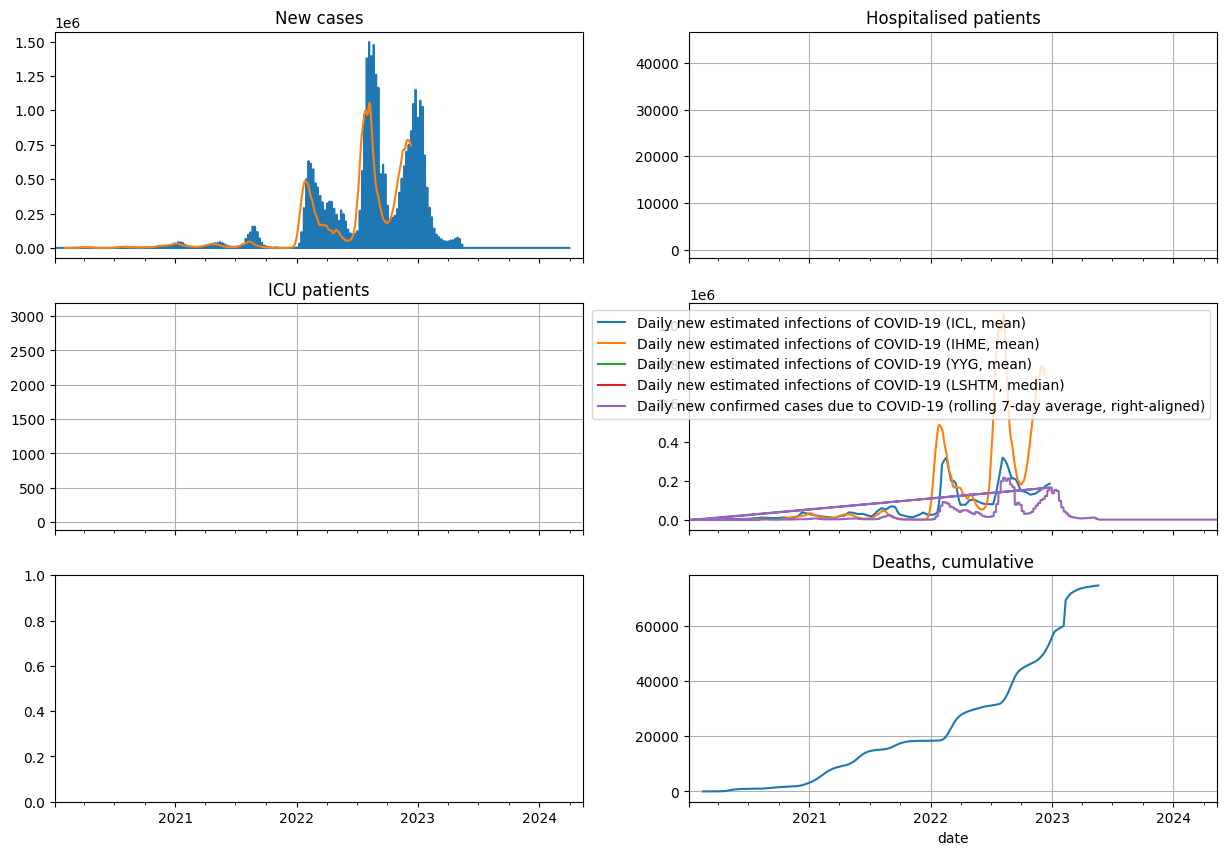

In [579]:
# Load the infection data
infection_data = pd.read_csv("/Users/thomasgaskin/Opinion_Dynamics_and_Covid/Infection_data/Our_World_In_Data/owid-covid-data.csv").drop(["continent", "location"], axis=1).set_index('date')
infection_data.index = pd.to_datetime(infection_data.index)
infection_data = infection_data[infection_data.iso_code=="JPN"].sort_index()

# Plot 
fig, axs = plt.subplots(figsize=(15, 10), nrows=3, ncols=2, sharex=True)
for idx, kind in enumerate(['new_cases', 'hosp_patients', 'icu_patients']):
    infection_data[kind].plot.line(ax=axs.flatten()[idx]) #.replace(0, np.nan).dropna().interpolate(axis=0, method='time').plot.line(ax=axs.flatten()[idx], label=kind)
    axs.flatten()[idx].grid()
    axs.flatten()[idx].set_title(kind)
infection_data['new_deaths_smoothed'].replace(0, np.nan).dropna().interpolate(axis=0, method='time').cumsum(axis="index").plot.line(ax=axs.flatten()[-1], label="Deaths, cumulative")
infected_estimated.index = pd.to_datetime(infected_estimated.index)
infected_estimated.plot.line(ax=axs.flatten()[3])
axs.flatten()[-1].grid()
infected_estimated['Daily new estimated infections of COVID-19 (IHME, mean)'].plot.line(ax=axs.flatten()[0])
axs.flatten()[0].set_title("New cases")
axs.flatten()[1].set_title("Hospitalised patients")
axs.flatten()[2].set_title("ICU patients")
axs.flatten()[-1].set_title("Deaths, cumulative")

In [398]:
# Calculate densities
N = infection_data["population"].mean()
infection_densities = pd.concat([
    infection_data['hosp_patients'].resample('D').interpolate(axis=0, method='time'),
    infection_data['icu_patients'].resample('D').interpolate(axis=0, method='time'),
], axis=1, ignore_index=False)[14:]
infection_densities["new_cases"] = infection_data['new_cases'][infection_data['new_cases'] > 0].resample('D').interpolate(method='time', axis=0)
infection_densities["deaths_cumulative"] = infection_data['new_deaths'][infection_data['new_deaths'] > 0].resample('D').interpolate(method='time', axis=0).cumsum()
infection_densities.columns = ["H", "C", "I", "D"]
infection_densities = infection_densities[["I", "H", "C", "D"]]
infection_densities /= N

In [406]:
infection_data.columns

Index(['iso_code', 'total_cases', 'new_cases', 'new_cases_smoothed',
       'total_deaths', 'new_deaths', 'new_deaths_smoothed',
       'total_cases_per_million', 'new_cases_per_million',
       'new_cases_smoothed_per_million', 'total_deaths_per_million',
       'new_deaths_per_million', 'new_deaths_smoothed_per_million',
       'reproduction_rate', 'icu_patients', 'icu_patients_per_million',
       'hosp_patients', 'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       'total_vaccinations_per_hundred', 'people_

In [528]:
import json
with open("/Users/thomasgaskin/Downloads/perCountryData.json") as f:
    d = json.load(f)

country_keys = dict((d['regions'][0]['distributions'][idx]['country'], idx) for idx in range(len(d['regions'][0]['distributions'])))
variants_japan = d['regions'][0]['distributions'][country_keys['Japan']]
del d

In [529]:
v = pd.concat([pd.DataFrame.from_dict({pd.to_datetime(variants_japan['distribution'][i]['week']): [v/variants_japan['distribution'][i]['total_sequences'] for v in variants_japan['distribution'][i]['cluster_counts'].values()]}, orient='index', columns=[k for k in variants_japan['distribution'][i]['cluster_counts'].keys()]) for i in range(len(variants_japan['distribution']))])

<Axes: xlabel='date'>

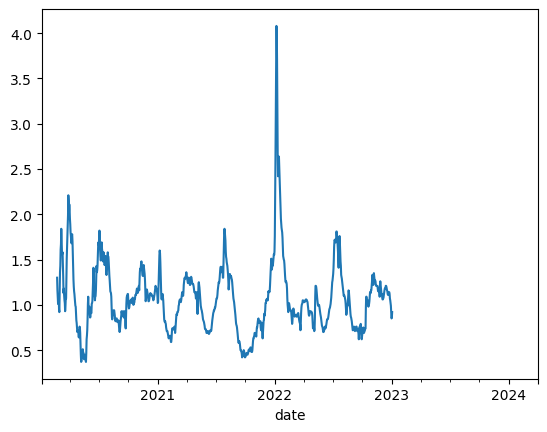

In [555]:
infection_data['reproduction_rate'].plot.line()

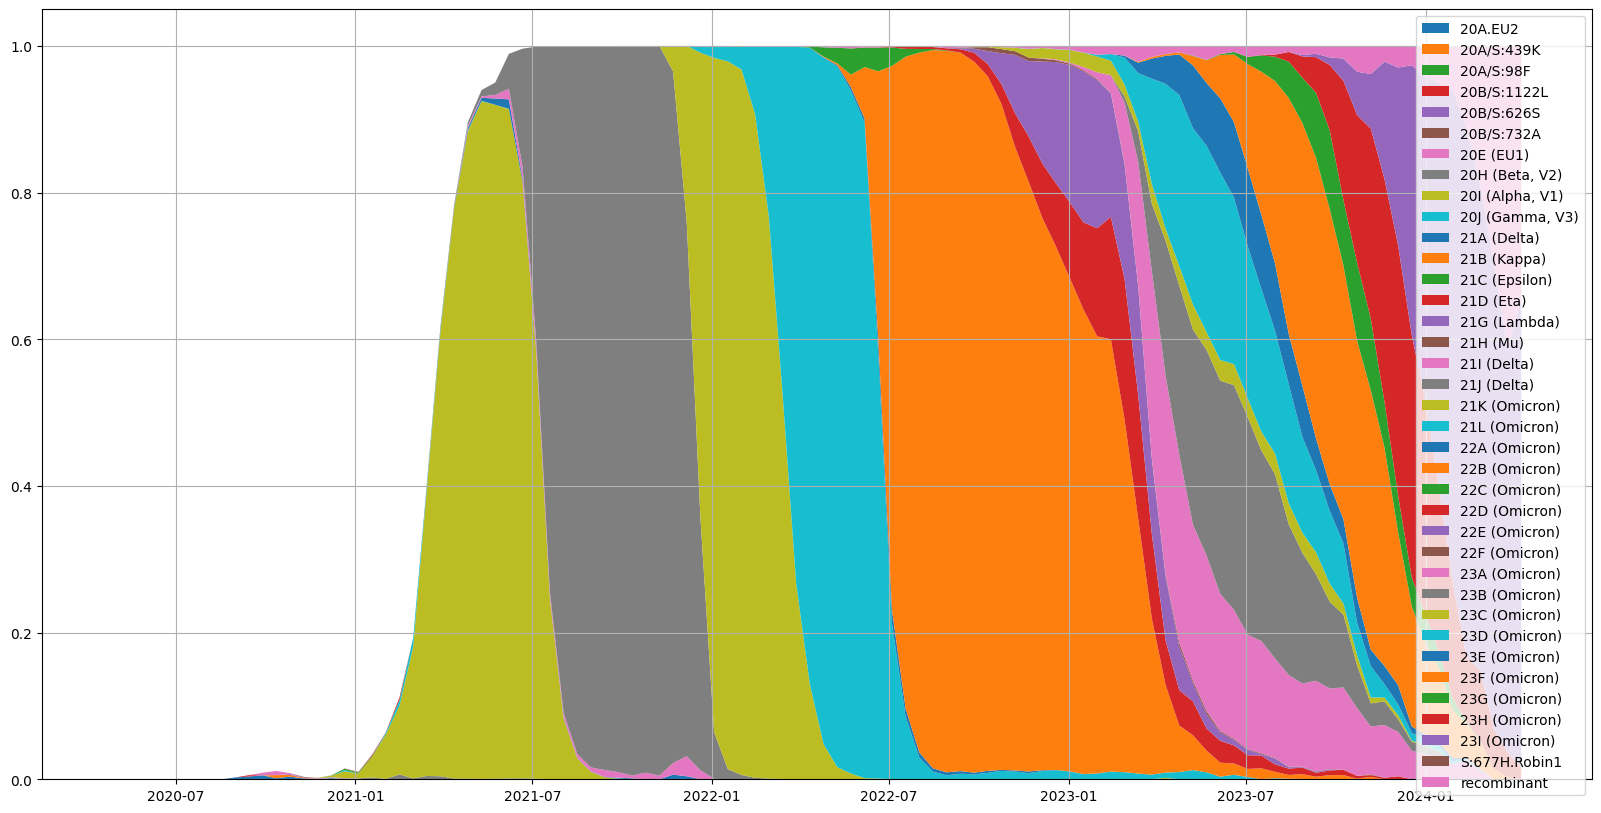

In [530]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.stackplot(v.index, *(v[v.columns[i]] for i in range(len(v.columns))), labels=v.columns);
ax.grid()
ax.legend()

In [402]:
# Initialise a neural network for the infection parameters
from include import neural_net

NN = neural_net.NeuralNet(
    input_size = 7, # We have seven compartments
    output_size = 6, # We want to learn 6 parameters: E, I, R, H, C, D
    num_layers=3,
    nodes_per_layer={"default": 20}, 
    activation_funcs={"default": "sigmoid", "layer_specific": {-1: "abs"}}, 
    biases={"default": None}
)
# All other parameters (optimizer, learning rate etc.) are the default -- see include.neural_net.NeuralNet for details

# Store the loss and parameters in an array
loss_ts, parameters_ts = [], []

In [405]:
# Initial state: one infected (Jan 19 2020)
initial_state = torch.tensor([1, 0, 1/N, 0, 0, 0, 0]).float()
state = initial_state.clone()
batch_size = 10
for e in range(1):
    
    # Make a parameter prediction
    parameters = NN(state)
    
    # Run the simulation for b steps:
    
    
    

tensor([0.4282, 0.0539, 0.0220, 0.2668, 0.2694, 0.0226],
       grad_fn=<AbsBackward0>)


In [31]:
def SEIRD(init_state: torch.Tensor, parameters: dict, *, dt: float) -> torch.Tensor:
    
    state = init_state.clone()
    
    state = state + torch.stack([
        
        # Susceptible
        - parameters["k_E"] * state[Compartments.susceptible.value] * state[Compartments.infected.value],
        
        # Exposed
        + parameters["k_E"] * state[Compartments.susceptible.value] * state[Compartments.infected.value] - (parameters["k_I"] + parameters["k_R"]) * state[Compartments.exposed.value],
        
        # Infected
        + parameters["k_I"] * state[Compartments.exposed.value] - (parameters["k_H"] + parameters["k_R"]) * state[Compartments.infected.value],
        
        # Recovered
        + parameters["k_R"] * (state[Compartments.exposed.value] + state[Compartments.infected.value] + state[Compartments.hospitalized] + state[Compartments.critical.value]),
        
        # Hospitalized
        + parameters["k_H"] * state[Compartments.infected.value] - (parameters["k_C"] + parameters["k_R"]) * state[Compartments.hospitalized.value],

        # Critical
        + parameters["k_C"] * state[Compartments.hospitalized.value] - (parameters["k_D"] + parameters["k_R"]) * state[Compartments.critical.value],
        
        # Deceased
        + parameters["k_D"] * state[Compartments.critical.value]
        
    ]) * dt
    
    return state

In [62]:
parameters = dict(k_E=0.5, k_I=0.1, k_H=0.01, k_C=0.005, k_D=0.001, k_R=0.01)
init_state = torch.zeros(7, 1, dtype=torch.float)
init_state[
    Compartments.susceptible.value
] = 0.99  # High number of susceptible agents
init_state[Compartments.infected.value] = (
    1.0 - init_state[Compartments.susceptible.value]
)  # Some infected agents

time_series = [init_state]

for _n in range(1000):
    time_series.append(SEIRD(time_series[-1], parameters, dt=0.2))
time_series = torch.stack(time_series)

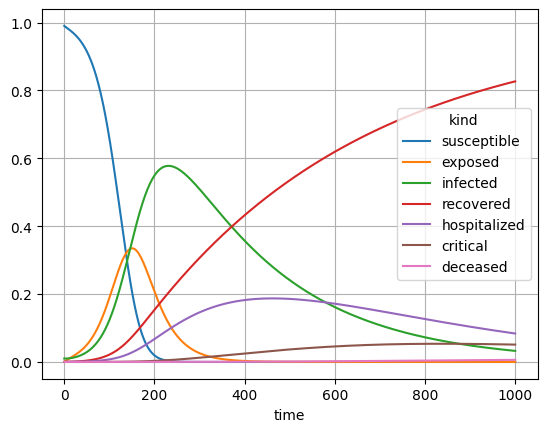

In [66]:
fig, ax = plt.subplots()
ax.grid()
time_series = xr.DataArray(time_series.squeeze(), dims=["time", "kind"], coords={"time": np.arange(time_series.shape[0]), "kind": [e.name for e in Compartments]})
time_series.plot(hue="kind", ax=ax);

In [164]:
anxiety_jp = pd.read_csv("/Users/thomasgaskin/Opinion_Dynamics_and_Covid/Opinion_data/Cross_Marketing_Japan/All_data/Anxiety-Anxiety level over the past week regarding Covid (1=None) (直近1週間の不安度).csv", index_col=0)
anxiety_jp.index = pd.to_datetime(anxiety_jp.index, dayfirst=True, format='mixed')

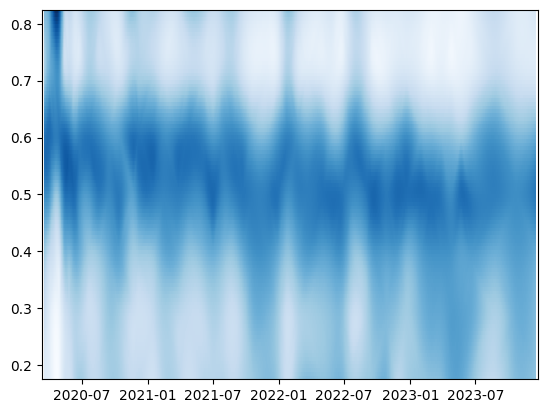

In [335]:
x, y, z = [], [], []
ds = anxiety_jp.stack().to_xarray().assign_coords({'level_1': np.array(list(range(1, len(anxiety_jp.columns)+1))) / (len(anxiety_jp.columns)+1)})
x.append(np.array([len(ds.coords['level_1']) * [_x] for _x in ds.coords['Date'].data]).flatten())
y.append(np.array(len(ds.coords['Date']) * list(ds.coords['level_1'])).flatten())
z.append(ds.data.flatten())
x = np.concatenate(x).astype(float)
y = np.concatenate(y)
z = np.concatenate(z)
x *= 1e-18
T = scipy.stats.binned_statistic_2d(x, y, z, bins=[100, 7], statistic='mean')
_t = (T.statistic / 100) / np.nansum(T.statistic / 100, axis=1, keepdims=True)
pts = np.meshgrid(0.5*(T.x_edge[1:]+T.x_edge[:-1]), 0.5*(T.y_edge[1:] + T.y_edge[:-1]))
coords = np.stack([pts[0], pts[1]], axis=-1).reshape(-1, 2)
vals = _t.transpose().flatten()
coords = coords[np.where(~np.isnan(vals))]
vals = vals[np.where(~np.isnan(vals))]
idx = np.random.choice(vals.shape[0], 10000)
dates_interp = np.arange(anxiety_jp.index.min(), anxiety_jp.index.max(), np.timedelta64(1, "D"))
X, Y = np.meshgrid(dates_interp.astype(float)*1e-15, 
                   np.linspace(coords.transpose()[1].min(), coords.transpose()[1].max(), 100))  # 2D grid for interpolation

interp = scipy.interpolate.griddata(coords[idx], vals[idx], (X, Y), method='cubic')
fig, ax = plt.subplots()
ax.pcolormesh(dates_interp, Y, interp, cmap='Blues')#, aspect='auto')

In [337]:
interp.shape

(100, 1380)

In [338]:
infection_data_japan.shape

(1548, 4)

In [339]:
anxiety_jp

,1,2,3,4,5,6,7
Date,,,,,,,
2020-03-12,5.3,8.3,12.7,21.5,24.1,12.6,15.4
2020-03-27,4.8,5.4,9.3,20.1,25.1,17.0,18.3
2020-04-13,2.4,3.0,7.5,14.5,23.1,19.6,29.9
2020-04-24,2.8,3.6,6.8,15.5,23.7,19.5,28.2
2020-05-15,7.2,7.6,14.7,23.6,24.9,10.4,11.5
2020-05-29,7.9,9.5,15.0,24.5,23.6,9.7,9.8
2020-06-12,10.6,11.1,17.4,25.0,20.9,7.6,7.5
2020-06-26,12.4,11.0,16.7,21.7,21.9,8.0,8.3
2020-07-17,10.2,8.7,12.8,19.9,23.4,12.3,12.6


In [340]:
infection_data_japan

,I,H,C,D
date,,,,
2020-01-05,NaN,NaN,NaN,NaN
2020-01-06,NaN,NaN,NaN,NaN
2020-01-07,NaN,NaN,NaN,NaN
2020-01-08,NaN,NaN,NaN,NaN
2020-01-09,NaN,NaN,NaN,NaN
...,...,...,...,...
2024-03-27,0.0,0.000099,0.000001,0.000603
2024-03-28,0.0,0.000099,0.000001,0.000603
2024-03-29,0.0,0.000099,0.000001,0.000603
